In [223]:
import pandas as pd

In [224]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(5)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


In [225]:
users = pd.read_csv('users_articles.csv')
users.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [226]:
from gensim.corpora.dictionary import Dictionary

<p style="background-color:#990000; text-size:10px;color:#fff; padding: 5px">При импорте из модуля gensim возникла проблема:<br> ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject. <br><br>
Решена проблема с помощью https://github.com/cocodataset/cocoapi/issues/509:<br>
pip install pycocotools --no-cache-dir --no-binary :all:



In [227]:
import re
import numpy as np
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from razdel import tokenize

import pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models import LdaModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [228]:
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

In [229]:
len(stopword_ru)

151

In [230]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

In [231]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 5min 40s, sys: 97.9 ms, total: 5min 40s
Wall time: 5min 41s


In [232]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 52s, sys: 82.4 ms, total: 3min 52s
Wall time: 3min 53s


In [233]:
news.head(3)           

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."


In [234]:
texts = [t for t in news['title'].values]

In [235]:
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [237]:
common_corpus[:10]

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 3),
  (90, 2),
  (91, 1)

In [66]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 2min 5s, sys: 1min 53s, total: 3min 58s
Wall time: 1min 28s


In [69]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [70]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'сторона', 'пять', 'очко', 'выезд', 'девять']


[(8, 0.4621342), (9, 0.4679601), (10, 0.04491594)]

In [79]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: фонд украина пенсия решение министр документ правительство
topic_1: погибнуть сотрудник американский источник данные проверка рф
topic_2: ребёнок мужчина женщина жизнь возраст товар километр
topic_3: млрд дональд турецкий студент рт турция заведение
topic_4: военный боевой космонавт мвд чёрный противник территория
topic_5: вода японский оборудование россия полоса сообщество специальный
topic_6: nn белоруссия место мышь германия белорусский первый
topic_7: китай китайский пилотировать захватить таиланд су студия
topic_8: температура остров египет день градус кожа сотня
topic_9: исследование очень статья первый выяснить научный помощь
topic_10: сша санкция россия закон законопроект актив против
topic_11: восток лечение офицер врач топливо осложнение ми
topic_12: украина украинский кость бомба минимальный донбасс тыс
topic_13: гражданин ракета пациент фронт народный россиянин артист
topic_14: газ фонд ввести обращение вирус список общественный
topic_15: nn россия рубль российский

In [81]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.26744,0.0,0.0,0.0,0.0,0.082765,0.0,0.055743,...,0.319304,0.099615,0.000000,0.0,0.0,0.0,0.0,0.0,0.167807,0.000000
1,4896,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.384186,...,0.591581,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,4897,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.448089,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.036616
3,4898,0.0,0.00000,0.0,0.0,0.0,0.0,0.152608,0.0,0.095657,...,0.000000,0.000000,0.100434,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,4899,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.150270,0.822633


In [82]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [150]:
user_articles_list = users['articles'].iloc[33]

In [156]:
def form_user_embeddings_df(func, stats='mean'):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: func(x, stats), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    
    return user_embeddings

In [160]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [173]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 1. Самостоятельно разобраться с тем, что такое tfidf 

(документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction);

TF-IDF -- term frequency-inverse document frequency, статистическая мера для оценки важности слова в контексте документа, являющегося частью коллекции документов.<br>
$ \text{tf-idf(term, document) = tf(term, document)} \cdot \text{idf(term)} $, где <br>

$\quad \text{idf}(term) = \log{\frac{1+n}{1+\text{df}(term)}} + 1$, где $n$ - общее количество документов в сете и $\text{df}(t)$ - количество документов в сете, которые содержат токен $t$.<br>

Класс TfidfVectorizer конвертирует коллекцию необработанных документов в матрицу функций TF-IDF. Эквивалентен CountVectorizer, за которым следует TfidfTransformer.<br>
По дефолту в классе TfidfVecrotizer результирующие tf-idf векторы нормализуются евклидовой нормой (l1).<br>

В TfidfVectorizer с smooth_idf=False добавляется счетчик "1" к idf вместо знаменателя idf: $\text{idf}(term) = \log{\frac{1+n}{\text{df}(term)}} + 1$.<br> С smooth_idf=True: $ \text{idf}(term) = \log{\frac{1+n}{1+\text{df}(term)}} $ 
<br>

Набор униграмм не может улавливать фразы и многословные выражения, фактически любую зависимость от порядка слов. Кроме того, моедль набора слов не учитывает возможные орфографические ошибки или производные слова. Вместо создания простого набора униграмм (n=1) можно было бы предпочесть набор биграмм (n=2), в котором будут учитываться вхождения пар следующих друг за другом слов (в TfidfVectorizer регулируется с помощью параметра ngram_range=(1, 1)). В качестве альтернативы можно было бы рассмотреть набор символьных n-граммов - представление, устойчивое к опечаткам, орфографическим ошибкам и производным (в TfidfVectorizer определяется параметр analyzer='char_wb', который создает n-граммы только из символов внутри границ слова, с пробелами с каждой стороны). Чтобы решить более широкую задачу понимания естественного языка, следует принимать во внимание локальную структуру предложений и абзацев, что в настоящее время выходит за рамки scikit-learn.

#### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

#### 3. Повторить п.2, но используя уже не медиану, а max

In [155]:
def get_user_embedding(user_articles_list, stats='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if stats == 'mean':
        user_vector = np.mean(user_vector, 0)  
    elif stats == 'median':
        user_vector = np.median(user_vector, 0)
    else:
        user_vector = np.max(user_vector, 0)
    return user_vector

In [157]:
user_embeddings_mean = form_user_embeddings_df(get_user_embedding)
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.121406,0.031942,0.035899,0.007966,0.000000,0.016312,0.082350,0.0,0.004325,...,0.137988,0.103552,0.110918,0.030666,0.0,0.062076,0.041179,0.011560,0.048501,0.013579
1,u108690,0.101411,0.073528,0.037793,0.000000,0.007234,0.014385,0.012380,0.0,0.005403,...,0.135439,0.029743,0.099134,0.100929,0.0,0.024954,0.006982,0.007340,0.085569,0.019103
2,u108339,0.056352,0.114086,0.029011,0.005921,0.016767,0.004373,0.057464,0.0,0.021756,...,0.273543,0.047784,0.037590,0.047050,0.0,0.036533,0.012377,0.016078,0.091290,0.037048


In [158]:
user_embeddings_median = form_user_embeddings_df(get_user_embedding, 'median')
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.070559,0.000000,0.000000,0.0,0.0,0.014646,0.039778,0.0,0.0,...,0.129277,0.040351,0.114141,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,u108690,0.085721,0.055880,0.018877,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.122192,0.008905,0.062950,0.122499,0.0,0.018230,0.000000,0.000000,0.067367,0.018442
2,u108339,0.057171,0.117799,0.024495,0.0,0.0,0.000000,0.021813,0.0,0.0,...,0.272075,0.034363,0.030991,0.053726,0.0,0.017327,0.005195,0.007765,0.062074,0.041592


In [159]:
user_embeddings_max = form_user_embeddings_df(get_user_embedding, 'max')
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.368889,0.133619,0.215395,0.047795,0.000000,0.036950,0.267250,0.0,0.025953,...,0.321693,0.357038,0.251596,0.093452,0.0,0.236412,0.170916,0.069361,0.291007,0.081472
1,u108690,0.250543,0.214247,0.115378,0.000000,0.043404,0.076277,0.043533,0.0,0.032418,...,0.308903,0.080952,0.261646,0.150781,0.0,0.078692,0.041892,0.028189,0.220966,0.047530
2,u108339,0.124223,0.161882,0.075399,0.023563,0.064334,0.015575,0.194025,0.0,0.113340,...,0.355504,0.127079,0.095576,0.095944,0.0,0.116366,0.052041,0.046284,0.230286,0.084977


In [162]:
X1 = pd.merge(user_embeddings_mean, target, 'left')
X2 = pd.merge(user_embeddings_median, target, 'left')
X3 = pd.merge(user_embeddings_max, target, 'left')

In [164]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X1['churn'], random_state=0)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3[['topic_{}'.format(i) for i in range(25)]], 
                                                    X3['churn'], random_state=0)

In [165]:
logreg_mean = LogisticRegression()
logreg_median = LogisticRegression()
logreg_max = LogisticRegression()

logreg_mean.fit(X1_train, y1_train)
logreg_median.fit(X2_train, y2_train)
logreg_max.fit(X3_train, y3_train)

LogisticRegression()

In [166]:
preds_mean = logreg_mean.predict_proba(X1_test)[:, 1]
preds_median = logreg_median.predict_proba(X2_test)[:, 1]
preds_max = logreg_median.predict_proba(X2_test)[:, 1]

In [168]:
def get_metrics(y_test, y_preds):
    precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    return precision, recall, thresholds, fscore, ix

In [128]:
print('for preds_mean:')
precision1, recall1, thresholds1, fscore1, ix1 = get_metrics(y1_test, preds_mean)

for preds_mean:
Best Threshold=0.263059, F-Score=0.707, Precision=0.658, Recall=0.763


In [171]:
print('for preds_median:')
precision2, recall2, thresholds2, fscore2, ix2 = get_metrics(y2_test, preds_median)

for preds_median:
Best Threshold=0.263949, F-Score=0.765, Precision=0.704, Recall=0.837


In [172]:
print('for preds_max:')
precision3, recall3, thresholds3, fscore3, ix3 = get_metrics(y3_test, preds_max)

for preds_max:
Best Threshold=0.263949, F-Score=0.765, Precision=0.704, Recall=0.837


In [174]:
import itertools

def plot_conf_matrix(y_test, y_preds, thresholds, ix):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                          title='Confusion matrix')
    plt.show()

Confusion matrix, without normalization
[[1658   97]
 [  59  186]]


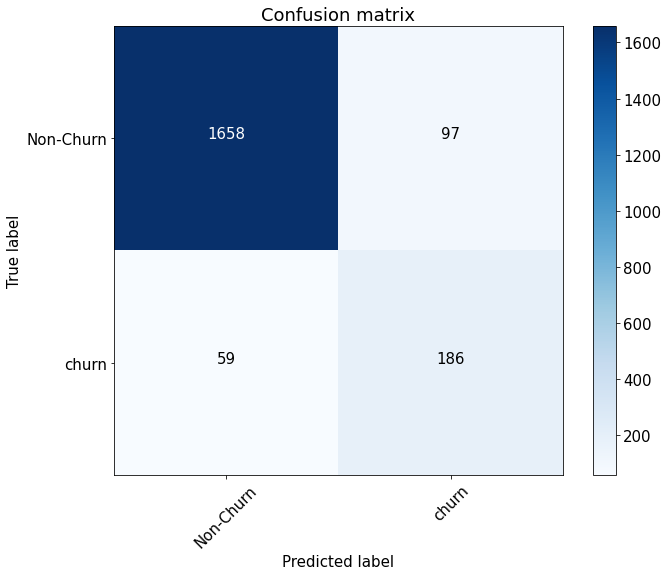

In [175]:
plot_conf_matrix(y1_test, preds_mean, thresholds1, ix1)

Confusion matrix, without normalization
[[1669   86]
 [  41  204]]


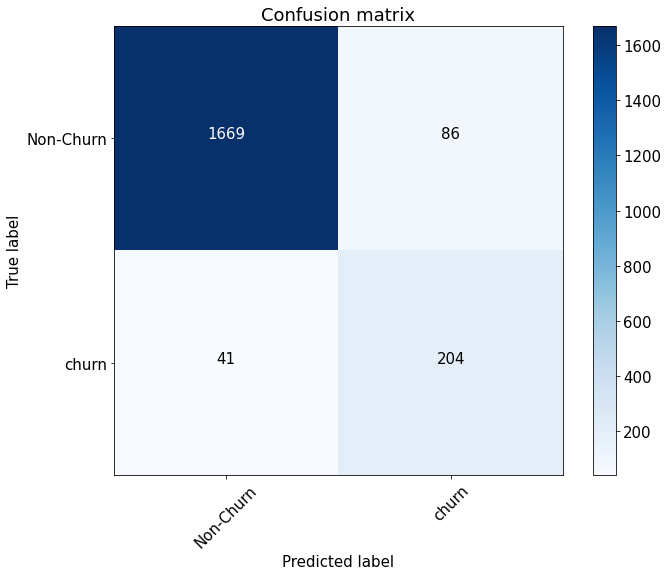

In [176]:
plot_conf_matrix(y2_test, preds_median, thresholds2, ix2)

Confusion matrix, without normalization
[[1669   86]
 [  41  204]]


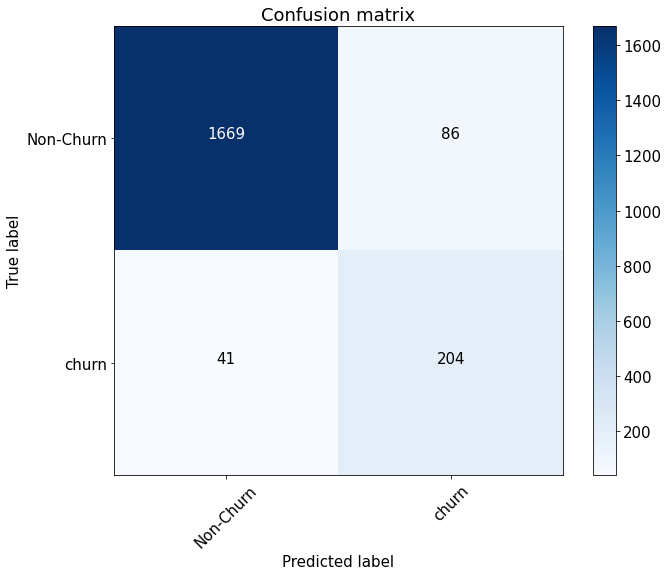

In [177]:
plot_conf_matrix(y3_test, preds_max, thresholds3, ix3)

In [180]:
roc_auc_mean = roc_auc_score(y1_test, preds_mean)
print('for preds_mean:', roc_auc_mean)

for preds_mean: 0.9557532414675273


In [181]:
roc_auc_median = roc_auc_score(y2_test, preds_median)
print('for preds_mean:', roc_auc_median)

for preds_mean: 0.9741380312808883


In [182]:
roc_auc_max = roc_auc_score(y3_test, preds_max)
print('for preds_mean:', roc_auc_max)

for preds_mean: 0.9741380312808883


#### 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

#### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [207]:
d = {'roc_auc': [roc_auc_mean, roc_auc_median, roc_auc_max], 
     'precision': [precision1[ix1], precision2[ix2], precision3[ix3]],
     'recall': [recall1[ix1], recall2[ix2], recall3[ix3]],
     'f_score': [fscore1[ix1], fscore2[ix2], fscore3[ix3]]}

In [208]:
df = pd.DataFrame(data=d, index=['mean', 'median', 'max'])

In [209]:
df

,roc_auc,precision,recall,f_score
mean,0.955753,0.658451,0.763265,0.706994
median,0.974138,0.704467,0.836735,0.764925
max,0.974138,0.704467,0.836735,0.764925


#### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

user_embedding_mean показал себя хуже, чем использование медианного значения и максимального. Такое различие может быть порождено неравномерным распределением данных. 
Почему метрики с использованием median и max показали идентичные результаты - это меня озадачивает.

#### Ссылки
1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation


Библиотеки, которые нужно установить:
gensim
razdel
pymorphy2
nltk